<a href="https://colab.research.google.com/github/Abby-Wale/CNN_For_Dementia/blob/main/Dementia_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet


In [ ]:
import opendatasets as od
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import math
import shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from PIL import Image
import torchvision
from torchvision import models
from torch.autograd import Variable

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/download?datasetVersionNumber=1'
od.download(dataset_url)

100%|██████████| 28.0M/28.0M [00:00<00:00, 59.7MB/s]


In [ ]:
dementia_data = '/content/alzheimer-mri-dataset/Dataset'

In [ ]:
for cls in os.listdir(dementia_data):
    print(cls, ':', len(os.listdir(dementia_data + '/' + cls)))

Very_Mild_Demented : 2240
Non_Demented : 3200
Moderate_Demented : 64
Mild_Demented : 896


In [ ]:
num_img = {}
for dir in os.listdir(dementia_data):
  num_img[dir] = len(os.listdir(os.path.join(dementia_data,dir)))

num_img.items()

def datafolder(folder, split):
    base_path = os.path.dirname(dementia_data)
    folder_path = os.path.join(base_path, folder)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        for dir in os.listdir(dementia_data):
            os.makedirs(os.path.join(folder_path, dir))
            for img in np.random.choice(a=os.listdir(os.path.join(dementia_data, dir)), size=(math.floor(split * num_img[dir]) - 5), replace=False):
                O = os.path.join(dementia_data, dir, img)
                D = os.path.join(folder_path, dir)
                shutil.copy(O, D)
                os.remove(O)
    else:
        print('the folder exists')

In [ ]:
datafolder('train', 0.7)
datafolder('val', 0.15)
datafolder('test', 0.15)

In [ ]:
train_dataset = '/content/alzheimer-mri-dataset/train'
val_dataset = '/content/alzheimer-mri-dataset/val'
test_dataset = '/content/alzheimer-mri-dataset/test'

In [ ]:
for cls in os.listdir(dementia_data):
    print(cls, ':', len(os.listdir(dementia_data + '/' + cls)))

Very_Mild_Demented : 15
Non_Demented : 15
Moderate_Demented : 17
Mild_Demented : 16


In [ ]:
for cls in os.listdir(train_dataset):
    print(cls, ':', len(os.listdir(train_dataset + '/' + cls)))

train_ds = ImageFolder(train_dataset)
print('Lenght of Training Dataset:',  len(train_ds))

Very_Mild_Demented : 1563
Non_Demented : 2235
Moderate_Demented : 39
Mild_Demented : 622
Lenght of Training Dataset: 4459


In [ ]:
for cls in os.listdir(val_dataset):
    print(cls, ':', len(os.listdir(val_dataset + '/' + cls)))

valid_ds = ImageFolder(val_dataset)
valid_count = len(valid_ds)
print('Lenght of Validation Dataset:',  len(valid_ds))

Very_Mild_Demented : 331
Non_Demented : 475
Moderate_Demented : 4
Mild_Demented : 129
Lenght of Validation Dataset: 939


In [ ]:
'''This code loads all the images from a specified directory (`data_dir`), 
applies a series of random transformations to each image to generate new 
augmented versions of them, and saves the augmented images to a new 
directory (`preview/`). You can adjust the number of augmented images 
generated for each original image by changing the range value in this 
line of code: `imgs = [transform(img) for _ in range(21)]` '''

# Define the transformations
transform = tt.Compose([
    tt.RandomRotation(40),
    tt.RandomHorizontalFlip(),
    tt.RandomVerticalFlip(),
    tt.RandomAffine(0, shear=20, scale=(0.8, 1.2)),
    tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    tt.RandomResizedCrop(150, scale=(0.8, 1.2)),
    tt.ToTensor()
])

# Set the path to the directory containing the images
# data_dir = 'data/train/cats'

# Create a new directory to store the augmented images
preview_dir = 'train_aug'
os.makedirs(preview_dir, exist_ok=True)

# Recursively search for image files in all subdirectories
for subdir, _, files in os.walk(train_dataset):
    for filename in files:
        # Load the image
        image_path = os.path.join(subdir, filename)
        img = Image.open(image_path)

        # Apply the transformations to the image
        imgs = [transform(img) for _ in range(16)]

        # Create a new subdirectory within the `preview/` directory
        # that corresponds to the original subdirectory
        subdir_name = os.path.basename(subdir)
        preview_subdir = os.path.join(preview_dir, subdir_name)
        os.makedirs(preview_subdir, exist_ok=True)

        # Save the transformed images to the new subdirectory
        for i, img in enumerate(imgs):
            save_path = os.path.join(preview_subdir, f'{filename}_{i}.jpeg')
            torchvision.utils.save_image(img, save_path)

In [ ]:
train_data = '/content/train_aug'

for cls in os.listdir(train_data):
    print(cls, ':', len(os.listdir(train_data + '/' + cls)))

train_ds = ImageFolder(train_data)
train_count = len(train_ds)
print('Lenght of Training Dataset:',  len(train_ds))

Very_Mild_Demented : 25008
Non_Demented : 35760
Moderate_Demented : 624
Mild_Demented : 9952
Lenght of Training Dataset: 71344


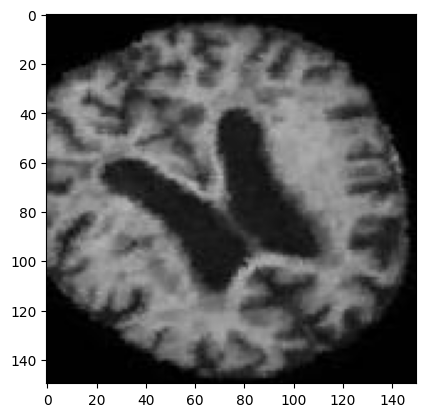

In [ ]:
img, label = train_ds[120]
plt.imshow(img)

In [ ]:
train_ds = ImageFolder(train_dataset, tt.ToTensor())
means = []
stdevs = []
for img, label in train_ds:
    means.append(np.mean(img.numpy(), axis=(1,2)))
    stdevs.append(np.std(img.numpy(), axis=(1,2)))
means = np.mean(means, axis=0)
stdevs = np.mean(stdevs, axis=0)
stats = (means.tolist(), stdevs.tolist())



train_ds = ImageFolder(train_data, tt.Compose([tt.Resize(224),                                                 
                                                  tt.ToTensor(), 
                                                  tt.Normalize(*stats)]))

valid_ds = ImageFolder(val_dataset, tt.Compose([tt.Resize(224),                                                 
                                                  tt.ToTensor(), 
                                                  tt.Normalize(*stats)]))

test_ds = ImageFolder(test_dataset, tt.Compose([tt.Resize(224),                                                 
                                                  tt.ToTensor(), 
                                                  tt.Normalize(*stats)]))

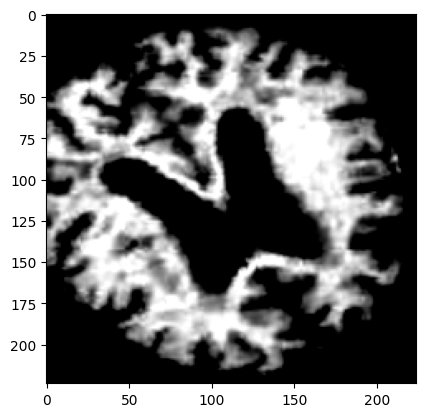

In [ ]:
'''image in index 120 after normalization'''
img, label = train_ds[120]
plt.imshow(img.permute((1, 2, 0)))

In [ ]:
train_dl = DataLoader(train_ds, 
                      batch_size = 64, 
                      shuffle=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size=32)

test_dl = DataLoader(test_ds, 
                    batch_size = 32)
                    

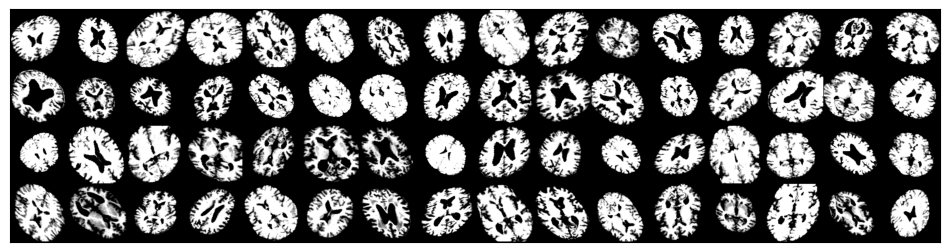

In [ ]:

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

In [ ]:
"""this block helps choose the available accelerator"""

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# class Identity(nn.Module):
#   def __init__(self):
#     super(Identity, self).__init__()

#   def forward(self, x):
#     return x

In [ ]:
model = models.vgg16(pretrained=True)

# the below will freeze some layers up to a particular
# so we could use back prop on a particular layer
# the weight of the layer won't change up to this point

for param in model.parameters():
  param.requires_grad = False



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 109MB/s]


In [ ]:
# model

In [ ]:
''' removes the avgpool and classifier is changed'''
model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
model.classifier = nn.Sequential(nn.Linear(512, 12),
                                 nn.ReLU(),
                                 nn.Linear(12, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 4))
# model.classifier = nn.Linear(512, 4)

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
input_tensor = torch.randn(64, 3, 224, 224)
output = model(input_tensor) 

In [ ]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:

model = model.to(device)

In [ ]:
#Optmizer and loss function
from torch.optim import Adam
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [ ]:
num_epochs=25

In [ ]:
#Model training and saving best model

best_accuracy=0.0
for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_dl):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    validation_accuracy=0.0
    for i, (images,labels) in enumerate(test_dl):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        validation_accuracy+=int(torch.sum(prediction==labels.data))
    
    validation_accuracy=validation_accuracy/valid_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+', Train Accuracy: '+str(train_accuracy)+', Validation Accuracy: '+str(validation_accuracy))
    
    #Save the best model
    if validation_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=validation_accuracy
    
       
